# Symbol-wise Autoencoder


# Import lib

In [1]:
import numpy as np
import matplotlib.pyplot as plt  

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Softmax

## Define the layers

In [8]:
class Normalization(Layer):

    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, symbols):        
        # Normalize power per symbol to 1
        en_moy = tf.sqrt(2 * tf.reduce_mean(tf.square(symbols)))
        symbols_norm = tf.divide(symbols, en_moy)
        
        return symbols_norm

class R2C(Layer):

    def __init__(self, **kwargs):
        super(R2C, self).__init__(**kwargs)

    def call(self, x):
        # Converts 2Nc real numbers into Nc complex numbers
        x_cplx = tf.complex(x[:, :1], x[:, 1:])
            
        return x_cplx

class C2R(Layer):

    def __init__(self, **kwargs):
        super(C2R, self).__init__(**kwargs)

    def call(self, y):
        #converts Nc complex numbers into 2Nc real numbers
        y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
            
        return y_real

class OneHot(Layer):

    def __init__(self, M, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.M = M

    def call(self, msg):
        
        one_hot_msg = tf.one_hot(msg, depth = M)
        
        return one_hot_msg

class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)
            
    def call(self, x, snr):
        # Adds random Gaussian noise to the input
        noise_stddev = tf.sqrt( 2 / tf.pow(10., snr/10.0))
        noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        noise_cplx = tf.complex(noise_r, noise_i, name="noise")

        return x  + noise_cplx

## Generate messages

In [3]:
def generate_ds_msg(epoch_len, batch_size, M):
    
    #Generate a dataset of 'epoch_len' batches of messages.
    #Each batch have a size 'batch_size' and consists of messages (symbols) betwen 0 and M-1
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    features_ds = tf.data.Dataset.from_tensor_slices(rand_msg)
    
    #The labels are the same as the features : this is an autoencoder, we want to predict the same message that has been sent.
    labels_ds = features_ds
    
    return (features_ds, labels_ds)

## Define the model

In [24]:
class Autoencoder(Model):

    def __init__(self, M, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        #Set the class' attributes
        self.M = M

        # Initialise the transmitter layers
        self.oh = OneHot(self.M)
        self.d1 = Dense(64, activation='elu')
        self.d2 = Dense(2, activation=None)
        self.norm = Normalization()
        self.r2c = R2C()
        
        # Initialise the channel
        self.ch = Channel()
        
        # Initialise the receiver layers
        self.c2r = C2R()
        self.d3 = Dense(64, activation='elu')
        self.d4 = Dense(self.M, activation=None)
        self.softm = Softmax()
    
    def call(self, inputs, snr):
        
        # Transmitter
        self.x1 = self.oh(inputs)
        self.x2 = self.d1(self.x1)
        self.x3 = self.d2(self.x2)
        self.x4 = self.norm(self.x3)
        self.x = self.r2c(self.x4)
    
        #Channel
        self.y = self.ch(self.x, snr)
        
        #Receiver
        self.pb1 = self.c2r(self.y)
        self.pb2 = self.d3(self.pb1)
        self.pb3 = self.d4(self.pb2)
        self.pb = self.softm(self.pb3)
    
        return self.pb

## loss function

In [5]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

## Instantiate the autoencoder

In [25]:
# Number of messages
M = 8
#Set the seeds
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Create the autoencoder
autoencoder = Autoencoder(M)

# See constellation before training

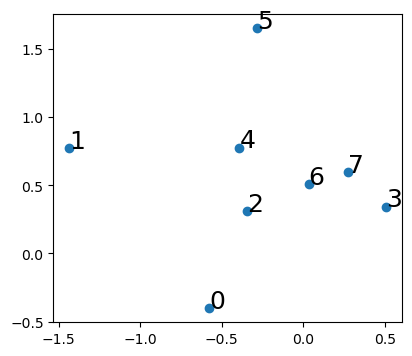

In [26]:
snr_eval = 10

# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(4.5, 4))
plt.scatter(np.real(x_np[:, 0]), np.imag(x_np[:, 0]))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i, 0]), np.imag(x_np[i, 0]), str(msg_np[i]), fontsize=18)

# Train

In [27]:
batch_size = 10000
epoch_size = 100
nb_epoch = 25
snr_training = 15

print('Symbol Error Rate after each epoch:')

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

for epoch in range(nb_epoch):
    
    # Create a random dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_msg(epoch_size, batch_size, M))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = autoencoder(features, snr_training)

            # Loss value for this batch.
            loss_value =  loss_func(y_true=labels, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    
    #Take the argmax of the probability distribution as the estimated message
    m_hat = tf.argmax(probas, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(labels-m_hat), 0, 1))/(batch_size)
    print(ser.numpy(), end=', ')
print('Done')

Symbol Error Rate after each epoch:
0.126, 0.0402, 0.0154, 0.0113, 0.0102, 0.0109, 0.0099, 0.0096, 0.0117, 0.0088, 0.011, 0.0104, 0.0116, 0.0099, 0.01, 0.0118, 0.0106, 0.0099, 0.0104, 0.01, 0.0111, 0.0098, 0.011, 0.0113, 0.0089, Done


## Evaluate the model

In [33]:
snr_range = np.arange(-5, 21)
results=[]
bs_eval = 100000

for snr_eval in snr_range:
    
    batch_msg = tf.random.uniform(shape=[bs_eval], minval=0, maxval=M, dtype=tf.int32)
    
    p_m = autoencoder(batch_msg, snr_eval)
    m_hat = tf.argmax(p_m, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(batch_msg-m_hat), 0, 1))/(bs_eval)
    print(ser.numpy(), end=', ')
    results.append(ser.numpy())

0.76541, 0.7489, 0.73393, 0.71146, 0.68787, 0.65946, 0.62934, 0.59435, 0.55347, 0.50906, 0.45764, 0.40165, 0.34635, 0.28711, 0.22757, 0.17013, 0.12051, 0.07701, 0.045, 0.02259, 0.01017, 0.00402, 0.00113, 0.00027, 3e-05, 0.0, 

In [34]:
AE_8 = np.array([0.76541, 0.7489, 0.73393, 0.71146, 0.68787, 0.65946, 0.62934, 0.59435, 0.55347, 0.50906, 0.45764, 0.40165, 0.34635, 0.28711, 0.22757, 0.17013, 0.12051, 0.07701, 0.045, 0.02259, 0.01017, 0.00402, 0.00113, 0.00027, 3e-05, 0.0])

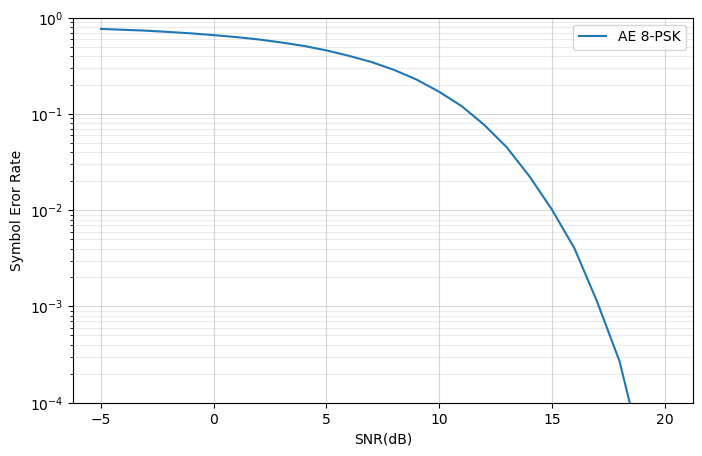

In [35]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, AE_8, label='AE 8-PSK')
# plt.semilogy(snr_range, results, label='AE 16-QAM')
plt.legend()
plt.xlabel('SNR(dB)')
plt.ylabel('Symbol Eror Rate');
plt.ylim(1e-4, 1)
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

## See learned constellation

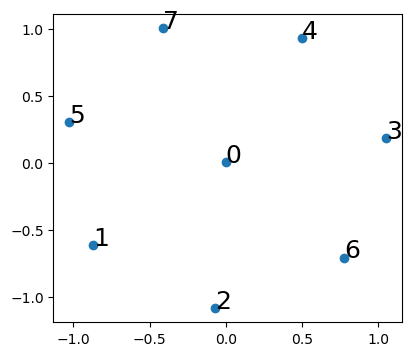

In [36]:
snr_eval = 10

# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(4.5, 4))
plt.scatter(np.real(x_np[:, 0]), np.imag(x_np[:, 0]))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i, 0]), np.imag(x_np[i, 0]), str(msg_np[i]), fontsize=18)